In [1]:
import re
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
import matplotlib as mpl
import seaborn as sns
from __future__ import division
import scipy.stats as st
%matplotlib inline
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = [10, 7.5]#[12, 9]#
mpl.rcParams['figure.dpi'] = 90
mpl.rcParams['savefig.dpi'] = 100
sns.set(style="whitegrid", color_codes=True)

# Import Cross Validation & Machine Learning Algorithms
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.isotonic import IsotonicRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [2]:
# functions
def icol(df, cols):
    return [i for i, dfCol in enumerate(df.columns) for col in cols if dfCol==col]

def appStrs(cols, string):
    return [c + string for c in cols]

def featureNorm(data, kind='std'):
    global mu
    global sigma
    if kind == 'range':
        mu = np.min(data)
        sigma = np.max(data) - np.min(data)
    else:
        mu = np.mean(data)
        sigma = np.std(data)
    return (data - mu) / sigma

In [3]:
yrType = '2016 Regular Season'

# load processed dataframe
plays = pd.read_csv('data/2016_reg_plays_gd.csv')
# play lables
playType = ['pass', 'rush']
playDir = ['left', 'up the middle', 'right']
playCols = [t + '_' + d[-6:] for t in playType for d in playDir]
# Feature column names: primarily cum sum stats columns - initially
col2cum = [c for c in plays.columns for x in ['type', 'dir', 'first', 'third', 'fourth', 'offense', 'passing', 'receiving', 'rushing'] if c.startswith(x) and not c.endswith('downs') and not c.endswith('_sh1') and not c.endswith('cum_dr') and not c.endswith('cum_gm')]
gcumCols = appStrs(col2cum, '_cum_gm')
dcumCols = appStrs(col2cum, '_cum_dr')
cumCols = gcumCols + dcumCols
prevPlay = appStrs(col2cum, '_sh1')
plays.pos_team = plays.pos_team.astype('category')
plays['pos_team_code'] = plays.pos_team.cat.codes
adfeat = ['quarter_code', 'qtr_timef', 'down', 'yards_to_go', 'score_diff', 'week', 'home', 'yardfield']
dumPrefix = ['off_', 'def_', 'day_']
catExc = ['pos_team', 'def_team', 'day_of_week']
dumCols = [c for c in plays.columns for d in dumPrefix if c.startswith(d) and c not in catExc]
features = cumCols + prevPlay + adfeat + dumCols
### - INCORPORATE THESE INTO plays_setup in future feature engineering
# DRIVE cumulative stats: fill NaN in columns with 0
plays[dcumCols] = plays[dcumCols].fillna(0)
# GAME cumulative stats: fill NaN in columns with forward fill
plays[gcumCols] = plays.groupby(['gsis_id', 'pos_team'])[gcumCols].fillna(method='ffill')
# GAME: cumulative stats: fill first play of game with 0
plays[gcumCols] = plays[gcumCols].fillna(0)
# Noncumulative, shifted stats: fill first play of game with 0
plays[prevPlay] = plays[prevPlay].fillna(0)
###
plays.play = plays.play.astype('category')
plays['play_code'] = plays.play.cat.codes
del features
features = np.load('data/features_dum.npy')
# features = [f for f in features if not f.startswith('rushing_loss') and f not in ['passing_int_cum_dr']]
features = np.array(features)
#features = np.load('data/features_step_lr10.npy')
# codes for split play_type and play_dir target variables
plays.play_type = plays.play_type.astype('category')
plays.play_dir = plays.play_dir.astype('category')

plays['play_type_code'] = plays.play_type.cat.codes
plays['play_dir_code'] = plays.play_dir.cat.codes
# data arrays
X = plays[features].apply(lambda x: featureNorm(x, kind='range'))
y1 = plays.play_type_code #plays[playCols]
y2 = plays.play_dir_code
play_code = plays.play_code
del plays

In [4]:
X = X.fillna(0)

In [5]:
X.describe()

,first_down_cum_gm,fourth_down_att_cum_gm,fourth_down_failed_cum_gm,offense_tds_cum_gm,offense_yds_cum_gm,passing_att_cum_gm,passing_cmp_cum_gm,passing_first_down_cum_gm,passing_incmp_cum_gm,passing_incmp_air_yds_cum_gm,...,def_SD,def_SEA,def_SF,def_TB,def_TEN,def_WAS,day_Monday,day_Saturday,day_Sunday,day_Thursday
count,31769.000000,31769.000000,31769.000000,31769.000000,31769.000000,31769.000000,31769.000000,31769.000000,31769.000000,31769.000000,...,31769.000000,31769.000000,31769.000000,31769.000000,31769.000000,31769.000000,31769.000000,31769.000000,31769.000000,31769.000000
mean,0.296270,0.053669,0.032086,0.152413,0.306623,0.282302,0.280899,0.256890,0.241030,0.201124,...,0.030816,0.031509,0.033744,0.030785,0.031792,0.032516,0.066102,0.051182,0.813529,0.069187
std,0.198902,0.111769,0.106085,0.164105,0.199715,0.185586,0.190406,0.184418,0.180479,0.156064,...,0.172822,0.174691,0.180571,0.172737,0.175449,0.177369,0.248465,0.220372,0.389492,0.253776
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.121212,0.000000,0.000000,0.000000,0.139028,0.129032,0.125000,0.125000,0.076923,0.071429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.272727,0.000000,0.000000,0.142857,0.293132,0.274194,0.250000,0.250000,0.230769,0.165025,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.454545,0.000000,0.000000,0.285714,0.453936,0.419355,0.425000,0.375000,0.346154,0.295567,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# configuration for cross-val selection
seed = 9
cv_n = 10
scoring = 'accuracy'

## FEATURE IMPORTANCES (Random Foreset)

In [10]:
def rfFeatureImp(X, y, seed, suf, plot=True):
    # Feature Importances from Random Forest
    forests = []

    forest = RandomForestClassifier(n_estimators=500,
                                    max_depth=None,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    n_jobs=-1, 
                                    random_state=seed)
    forest.fit(X, y)
    # feature importance, std, and max sorted index
    importance = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importance)[::-1]

    if plot:
        # Plot the Forest's feature importances for each CV split
        fig, ax = plt.subplots(figsize=(34,9))


        ax.set_title("Feature importances: Overall RF")
        ax.bar(range(len(importance)), importance[indices],
               color="b", yerr=std[indices], align="center")
        ax.set_xticks(range(len(importance)))
        ax.set_xticklabels(features[indices], rotation='vertical')
        # ax.set_xticklabels(map(str, indices), rotation='vertical')
        ax.set_xlim([-1, len(importance)])
        fig = plt.gcf()
        fig.savefig('figs/rf_featImp_play'+suf+'.png', bbox_inches='tight', pad_inches=0)
        plt.show()
    return importance, std, indices

* Find feature importances and algorithm comparisons for the 6 class target classification combining play type and direction.
* Observed performance did not significantly exceed simply labeling every example with the most prevalent class (Dum classifier) and most features were minimally informative.
* Thus, I decided to split the problem into a binary classification of play type (pass vs. rush) followed by a multiclass classification of play direction (left vs. middle vs. right).


PLAY TYPE (pass vs rush)


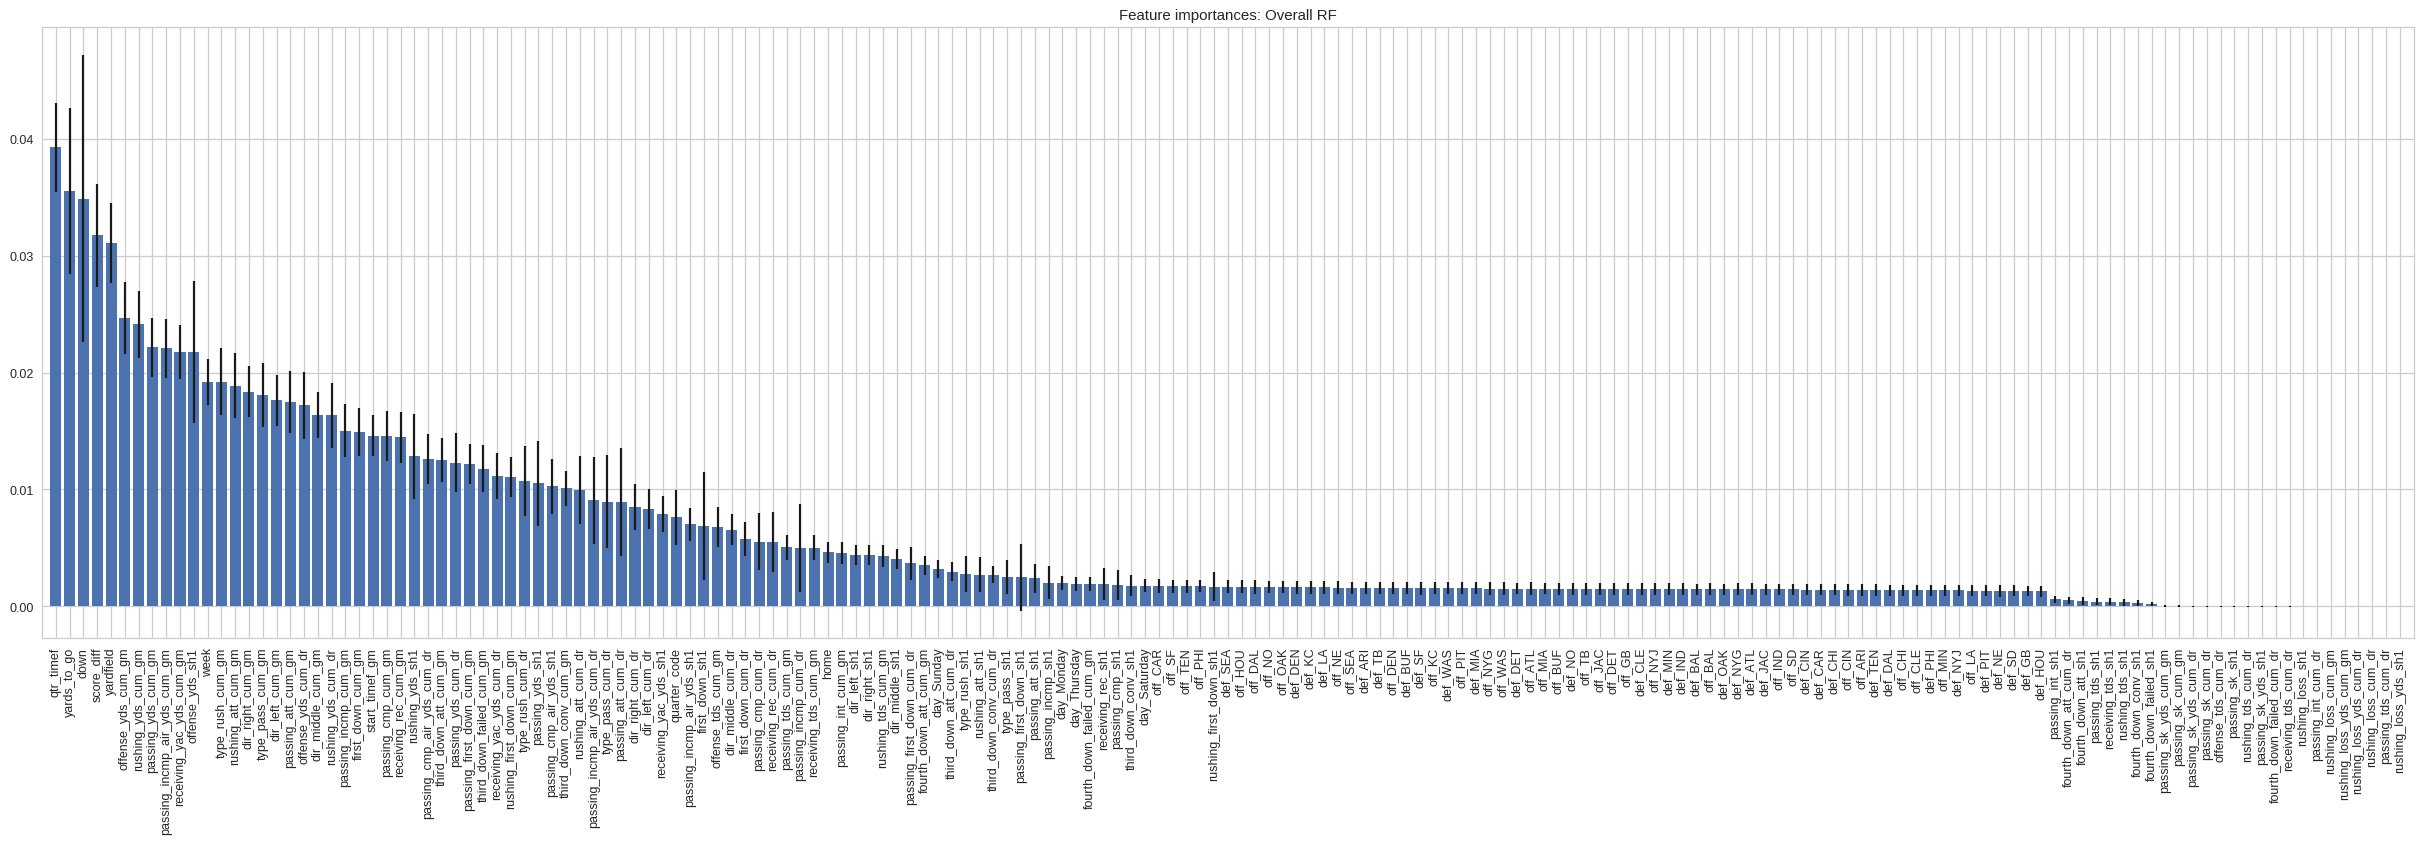

In [14]:
# get OVERALL feature importances for play type
print('PLAY TYPE (pass vs rush)')
impTyp, stdTyp, idxTyp = rfFeatureImp(X, y1, seed, suf='Typ')

In [40]:
features[idxTyp[:80]]

array([u'qtr_timef', u'yards_to_go', u'down', u'score_diff', u'yardfield',
       u'offense_yds_cum_gm', u'rushing_yds_cum_gm', u'passing_yds_cum_gm',
       u'passing_incmp_air_yds_cum_gm', u'receiving_yac_yds_cum_gm',
       u'offense_yds_sh1', u'week', u'type_rush_cum_gm',
       u'rushing_att_cum_gm', u'dir_right_cum_gm', u'type_pass_cum_gm',
       u'dir_left_cum_gm', u'passing_att_cum_gm', u'offense_yds_cum_dr',
       u'dir_middle_cum_gm', u'rushing_yds_cum_dr',
       u'passing_incmp_cum_gm', u'first_down_cum_gm', u'start_timef_gm',
       u'passing_cmp_cum_gm', u'receiving_rec_cum_gm', u'rushing_yds_sh1',
       u'passing_cmp_air_yds_cum_dr', u'third_down_att_cum_gm',
       u'passing_yds_cum_dr', u'passing_first_down_cum_gm',
       u'third_down_failed_cum_gm', u'receiving_yac_yds_cum_dr',
       u'rushing_first_down_cum_gm', u'type_rush_cum_dr',
       u'passing_yds_sh1', u'passing_cmp_air_yds_sh1',
       u'third_down_conv_cum_gm', u'rushing_att_cum_dr',
       u'passing_in

In [38]:
np.savez('data/feature_imp_rf_type', impTyp=impTyp, stdTyp=stdTyp, idxTyp=idxTyp)

PLAY DIRECTION



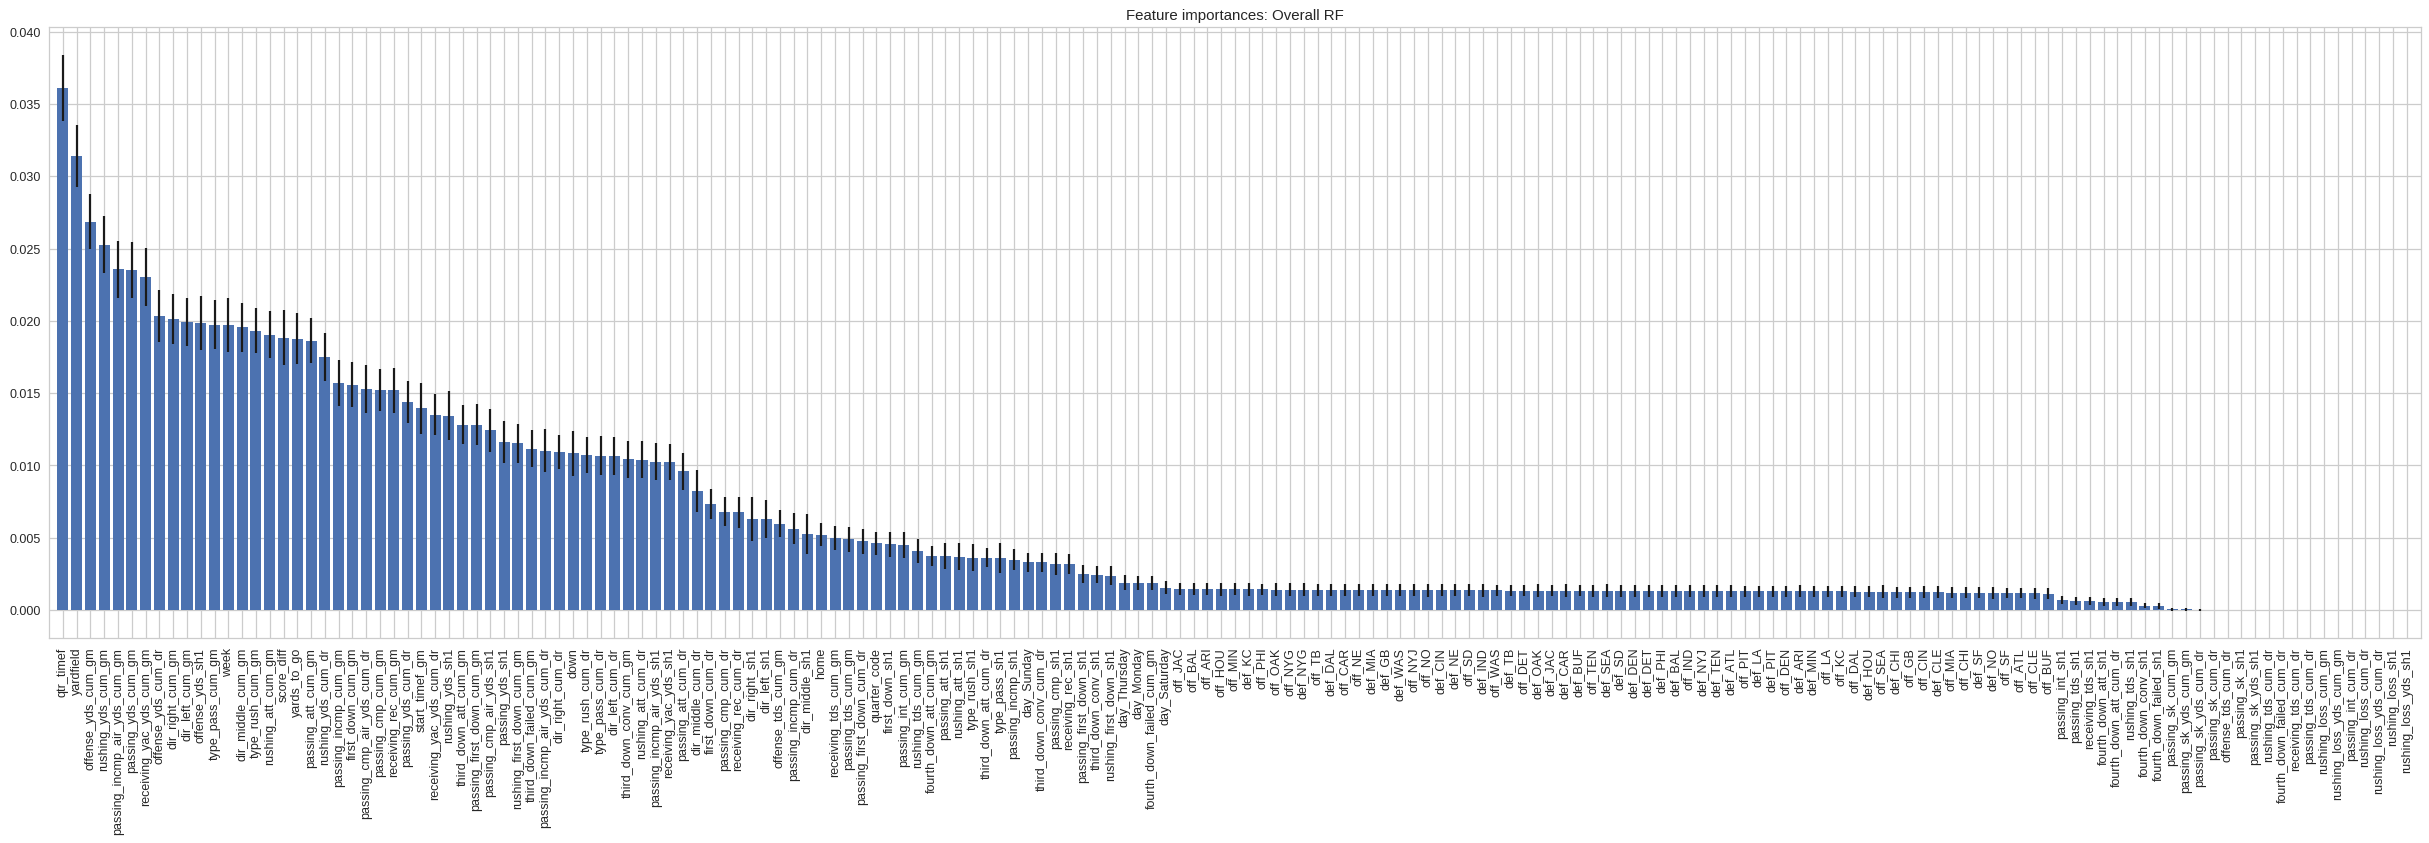

In [18]:
# get OVERALL feature importances for play direction
print('PLAY DIRECTION\n')
impDir, stdDir, idxDir = rfFeatureImp(X, y2, seed, suf='Dir')

In [ ]:
np.savez('data/feature_imp_rf_dir', impDir=impDir, stdDir=stdDir, idxDir=idxDir)

In [6]:
# load Play Type RF feature importances, stds, and ordered indices
f = np.load('data/feature_imp_rf_type.npz')
impTyp = f['impTyp']
stdTyp = f['stdTyp']
idxTyp = f['idxTyp']
topf = features[idxTyp[:20]]

In [7]:
topf

array([u'qtr_timef', u'yards_to_go', u'down', u'score_diff', u'yardfield',
       u'offense_yds_cum_gm', u'rushing_yds_cum_gm', u'passing_yds_cum_gm',
       u'passing_incmp_air_yds_cum_gm', u'receiving_yac_yds_cum_gm',
       u'offense_yds_sh1', u'week', u'type_rush_cum_gm',
       u'rushing_att_cum_gm', u'dir_right_cum_gm', u'type_pass_cum_gm',
       u'dir_left_cum_gm', u'passing_att_cum_gm', u'offense_yds_cum_dr',
       u'dir_middle_cum_gm'], 
      dtype='<U28')

## GRIDSEARCH Random Forest # of TREES with CV

In [9]:
# GRIDSEARCH # of TREES with CV
print('PLAY TYPE: pass vs rush\n searching n_estimators...')
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
params = {'n_estimators': [500, 1000, 1500, 2000, 3000, 4000]}
clf = GridSearchCV(rf, params, scoring='accuracy', n_jobs=-1)
clf.fit(X[topf], y1)

PLAY TYPE: pass vs rush
 searching n_estimators...


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [500, 1000, 1500, 2000, 3000, 4000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [9]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

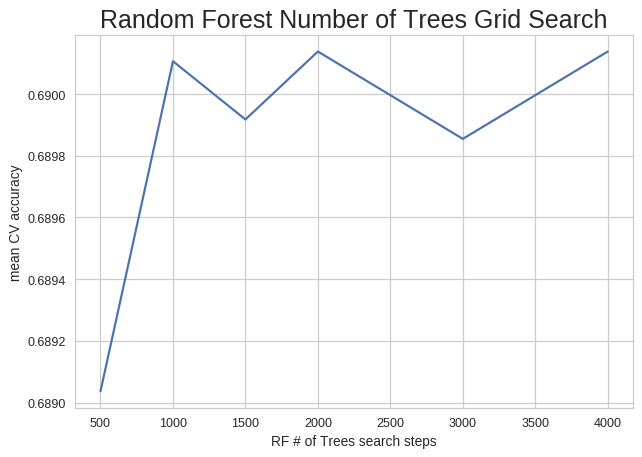

In [11]:
plt.plot(params['n_estimators'], clf.cv_results_['mean_test_score'])
#plt.xticks(range(len(params['n_estimators'])))
plt.xlabel('RF # of Trees search steps')
plt.ylabel('mean CV accuracy')
plt.title('Random Forest Number of Trees Grid Search', fontsize=20)
fig = plt.gcf()
fig.savefig('figs/rf_gdSearch_nTrees_playTyp.png', bbox_inches='tight', pad_inches=0)
plt.show()

## GRIDSEARCH Random Forest max DEPTH with CV

In [12]:
# GRIDSEARCH max DEPTH with CV
print('PLAY TYPE: pass vs rush]\n searching max_depth...')
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
dep1steps = range(len(topf)+1)[1:]
params = {'max_depth': dep1steps}
clfd = GridSearchCV(clf.best_estimator_, params, scoring='accuracy', n_jobs=-1)
clfd.fit(X[topf], y1)

PLAY TYPE: pass vs rush]
 searching max_depth...


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [25]:
clfd.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

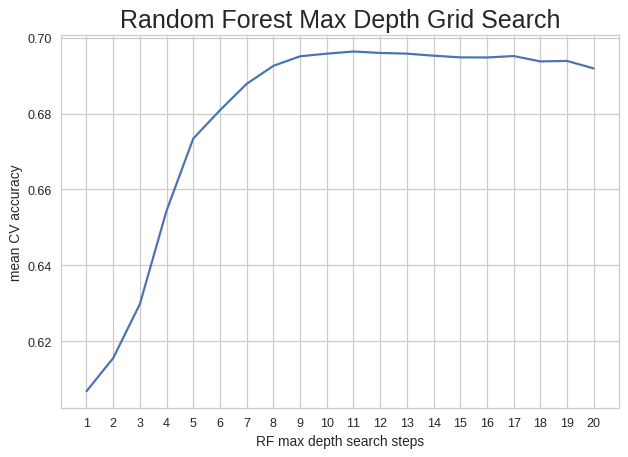

In [13]:
plt.plot(dep1steps, clfd.cv_results_['mean_test_score'])
plt.xticks(dep1steps)
plt.xlabel('RF max depth search steps')
plt.ylabel('mean CV accuracy')
plt.title('Random Forest Max Depth Grid Search', fontsize=20)
fig = plt.gcf()
fig.savefig('figs/rf_gdSearch_depth_playTyp.png', bbox_inches='tight', pad_inches=0)
plt.show()

## Step-wise Classification

In [9]:
def stepwiseClf(alg, X, y, impf, cv_n, seed, scoring='accuracy', plot=True, verbose=False):
    '''
    Step-wise Classifier w/ cross-validation
    '''
    accStep, iStep, resultsStep = [], [], []
    for step in range(len(impf)+1):
        s = step + 1
        impfeat = impf[:s]
        x = X[impfeat]

        kf = KFold(n_splits=cv_n, random_state=seed)
        cv_results = cross_val_score(alg, x, y, cv=kf, scoring=scoring)
        resultsStep.append(cv_results)
        accStep.append([cv_results.mean(), cv_results.std()])
        iStep.append(step)
        if verbose:
            print("LR-{0}: {1} ({2}) acc (std)".format(step, cv_results.mean(), cv_results.std()))
    dfa = pd.DataFrame(accStep, columns=['acc', 'sd'])
    dfa['accDiff'] = dfa.acc.diff()
    if plot:
        # Plot the mean accuracy and std from CV splits, for features included
        fig, ax = plt.subplots(figsize=(20,9))


        ax.set_title("Stepwise Accuracy by Features added")
        ax.plot(range(len(dfa.acc)), dfa.acc,
               color="b")
        ax.set_xlabel('Feature Steps')
        ax.set_ylabel('Accuracy score')
        ax.set_xticks(range(len(dfa.acc)+1))
        ax.set_xticklabels(impf, rotation='vertical')
        # ax.set_xticklabels(map(str, indices), rotation='vertical')
        ax.set_xlim([-1, len(impf)])
        plt.show()
    return dfa            

In [10]:
rf = RandomForestClassifier(n_estimators=2000, max_depth=13, n_jobs=-1)

## Multiclass (6: pass-left, pass-middle, pass-right, rush-left, rush-middle, vs rush-right)

Step-wise RF
 Play 
 10-fold CV


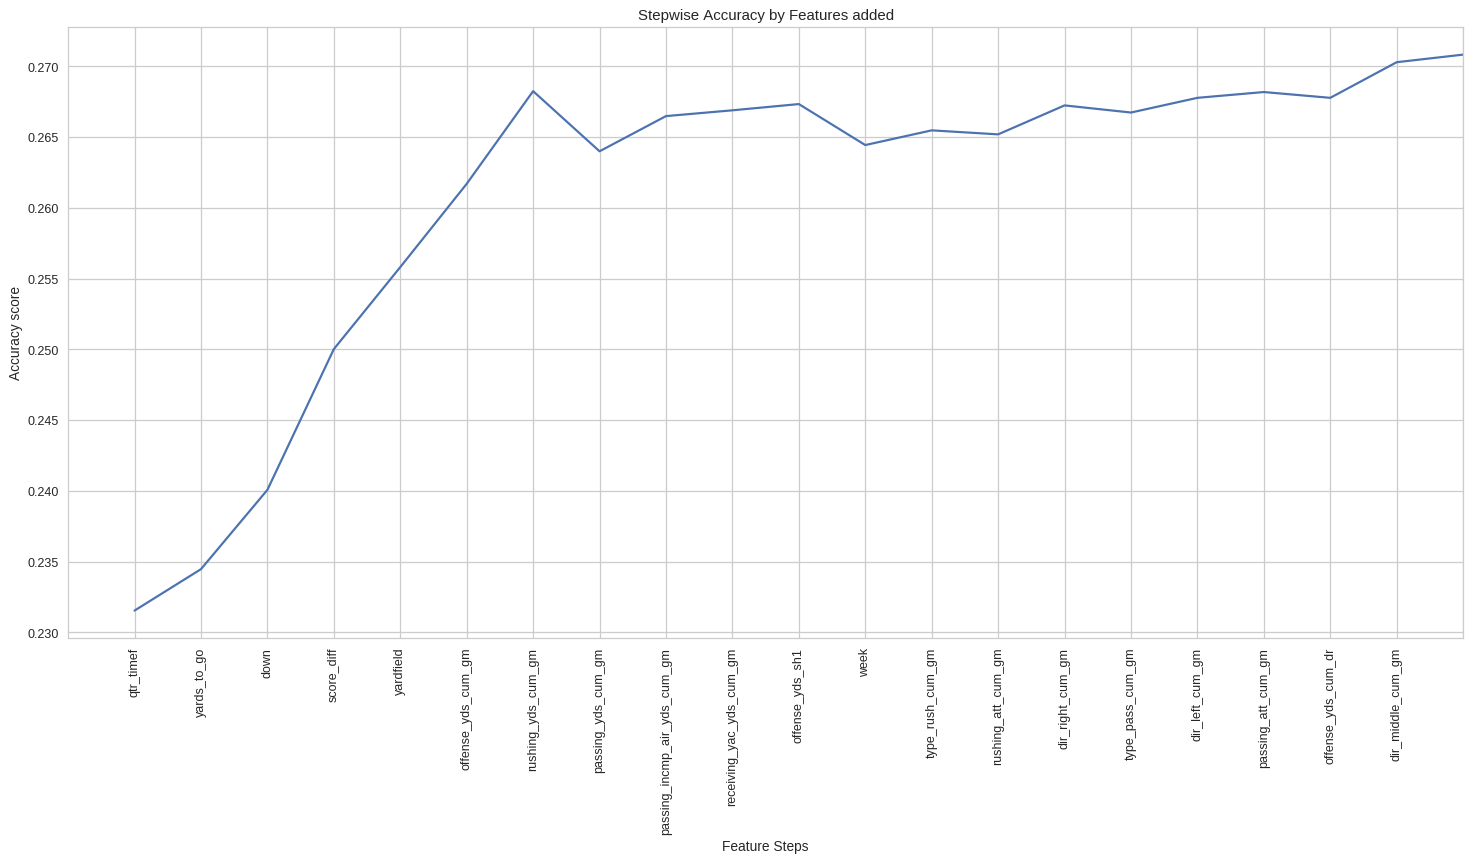

CPU times: user 3h 47min 54s, sys: 32min 4s, total: 4h 19min 58s
Wall time: 1h 21min 49s


In [25]:
%%time
print('Step-wise RF\n Play \n 10-fold CV')
dfstep = stepwiseClf(rf, X, play_code, topf, cv_n, seed, scoring, plot=True)

## Binary (Play Type: pass vs rush)

Step-wise RF
 Play TYPE: pass vs rush
 10-fold CV


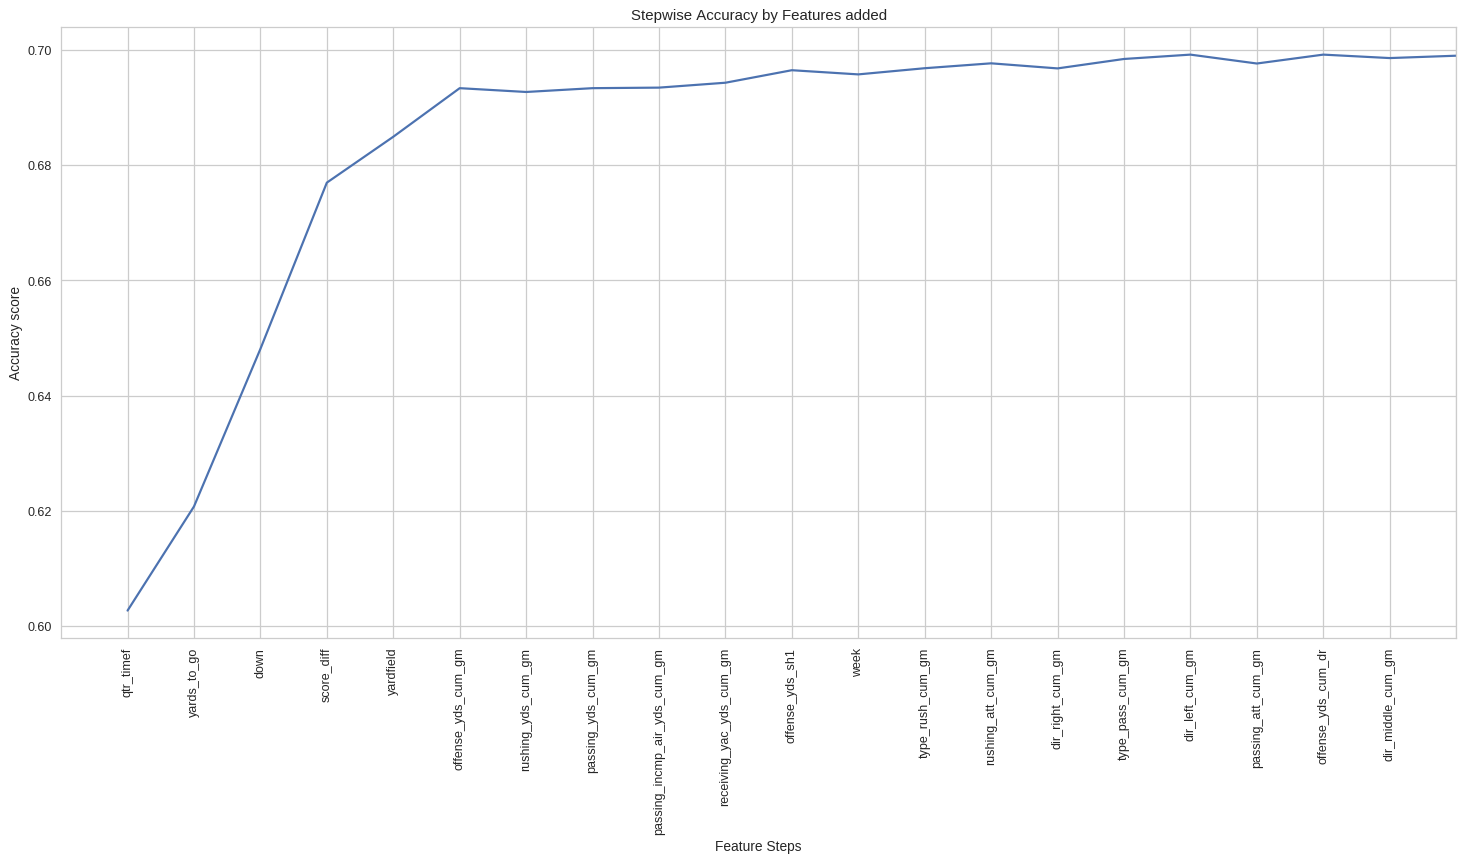

CPU times: user 3h 36min 42s, sys: 31min 38s, total: 4h 8min 21s
Wall time: 1h 18min 57s


In [20]:
%%time
print('Step-wise RF\n Play TYPE: pass vs rush\n 10-fold CV')
dfstep = stepwiseClf(rf, X, y1, topf, cv_n, seed, scoring, plot=True)

## Multiclass (3, Play Direction: left, middle, vs right)

In [11]:
# load Play Direction RF feature importances, stds, and ordered indices
f = np.load('data/feature_imp_rf_dir.npz')
impDir = f['impDir']
stdDir = f['stdDir']
idxDir = f['idxDir']

In [12]:
topf = features[idxDir[:20]]
topf

array(['qtr_timef', 'yardfield', 'offense_yds_cum_gm',
       'rushing_yds_cum_gm', 'passing_incmp_air_yds_cum_gm',
       'passing_yds_cum_gm', 'receiving_yac_yds_cum_gm', 'week',
       'offense_yds_cum_dr', 'dir_right_cum_gm', 'dir_left_cum_gm',
       'type_pass_cum_gm', 'offense_yds_sh1', 'dir_middle_cum_gm',
       'score_diff', 'type_rush_cum_gm', 'rushing_att_cum_gm',
       'passing_att_cum_gm', 'yards_to_go', 'rushing_yds_cum_dr'], 
      dtype='|S28')

Step-wise RF
 Play DIR: left vs middle vs right
 10-fold CV


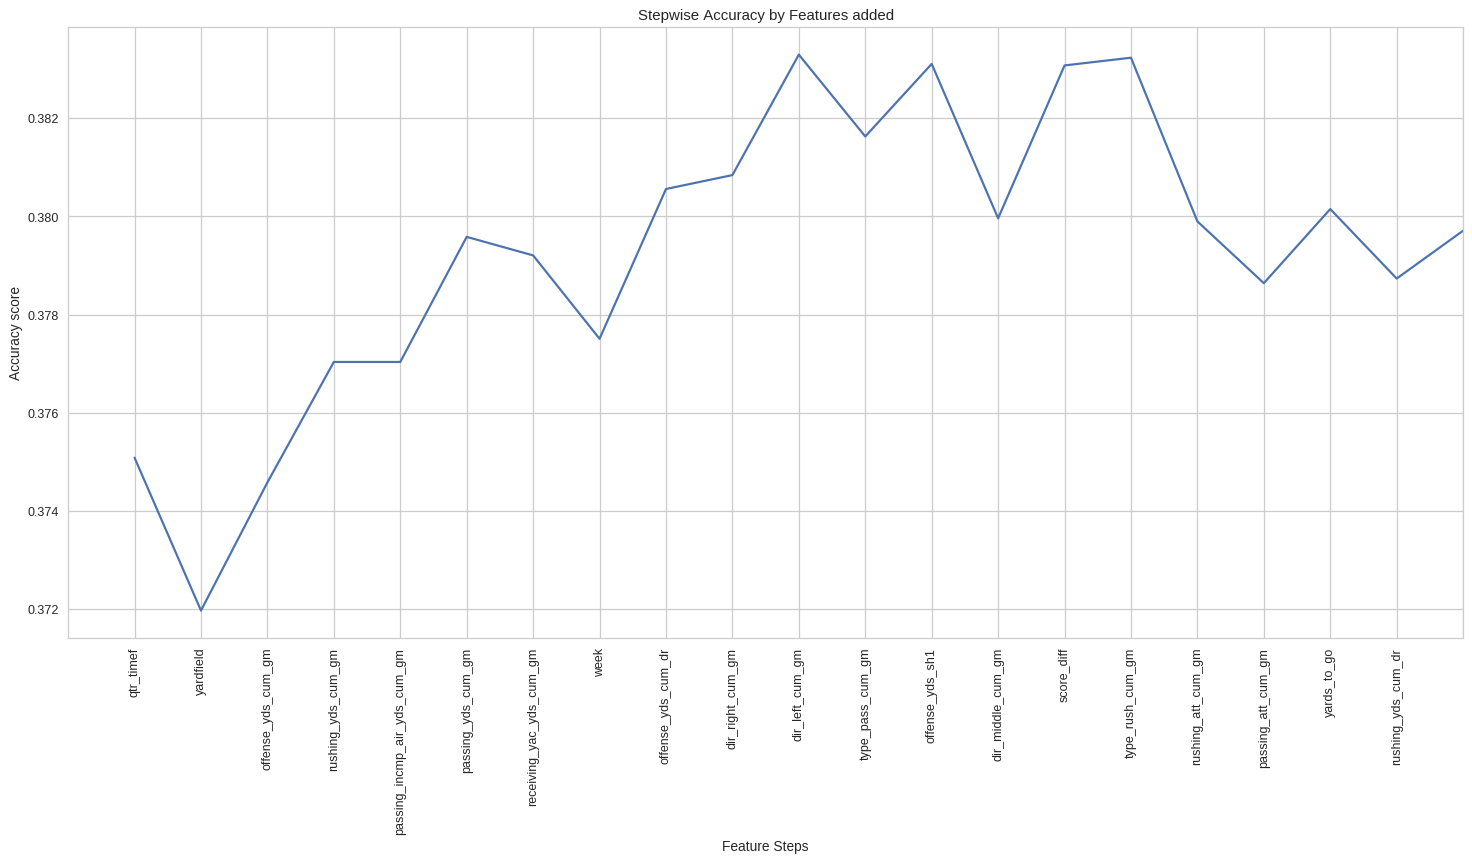

CPU times: user 4h 4s, sys: 30min 18s, total: 4h 30min 23s
Wall time: 1h 24min 26s


In [13]:
%%time
print('Step-wise RF\n Play DIR: left vs middle vs right\n 10-fold CV')
dfstep = stepwiseClf(rf, X, y2, topf, cv_n, seed, scoring, plot=True)

# Greedy Feature Selection based on Logistic Regression coefficients 
w/ Cross validation

# 10-fold Cross Validation

## Target: Play Type

In [ ]:
# Binary play type (pass vs rush)
# greedy recursive feature elimination by 10-fold cross-validation
cv_n = 10
seed = 9
kf = KFold(n_splits=cv_n, random_state=seed)
lr = LogisticRegression(multi_class='ovr', solver='lbfgs', class_weight='balanced')
fSelect_type = RFECV(lr, step=1, cv=kf, n_jobs=-1)
fSelect_type.fit(X, plays.play_type_code)
featTyp = features[fSelect_type.support_]

## Target: Play Direction

In [ ]:
# 3 class play direction (left, middle, right)
# greedy recursive feature elimination by 10-fold cross-validation
cv_n = 10
seed = 9
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
fSelect_dir = RFECV(lr, step=1, cv=kf, n_jobs=-1)
fSelect_dir.fit(X, plays.play_dir_code)
featDir = features[fSelect_dir.support_]

In [ ]:
np.savez('data/greedy_sel_features_cv10_lr', featTyp=featTyp, featDir=featDir)

## TEST Algorithms

In [8]:
def testAlgorithms(models, X, y, featTup, cv_n, seed, scoring, suf, plot=True):
    # test each algorithm
    results = []
    names = []
    for name, model, colinearity in models:
        # select either (non)colinear features depending on model assumptions
        if colinearity:
            x = X[featTup[0]]
        else:
            x = X[featTup[1]]
        kf = KFold(n_splits=cv_n, random_state=seed)
        if scoring == 'predict':
            cv_results = cross_val_predict(model, x, y, cv=cv_n, method=scoring, n_jobs=-1)
        else:
            cv_results = cross_val_score(model, x, y, cv=cv_n, scoring=scoring, n_jobs=-1)
            print("{0}: {1} ({2}) acc (std)".format(name, cv_results.mean(), cv_results.std()))
        results.append(cv_results)
        names.append(name)        
        
    if plot:
        # Plot & Compare model's performance
        fig, ax = plt.subplots()
        ax.boxplot(results, notch=False, patch_artist=True)
        ax.set_xticklabels(names)
        plt.title('Algorithm Accuracy (Play '+ suf +')', fontsize=20)
        fig = plt.gcf()
        fig.savefig('figs/base_alg_acc_play'+ suf+'.png', bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.show()
    return results, names

In [6]:
# LR and LDA features from LR greedy feature elimination
f = np.load('data/greedy_sel_features_cv10_lr.npz')
featTyp = f['featTyp']
featDir = f['featDir']

In [7]:
# load Play DIRECTION RF feature importances, stds, and ordered indices
f = np.load('data/feature_imp_rf_dir.npz')
impDir = f['impDir']
stdDir = f['stdDir']
idxDir = f['idxDir']

In [8]:
# load Play TYPE RF feature importances, stds, and ordered indices
f = np.load('data/feature_imp_rf_type.npz')
impTyp = f['impTyp']
stdTyp = f['stdTyp']
idxTyp = f['idxTyp']

In [18]:
# configuration for cross-val selection
seed = 9
cv_n = 10
scoring = 'accuracy'

In [20]:
# setup MULTICLASS models
models = []
models.append(('RFg', RandomForestClassifier(criterion='gini', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('RFe', RandomForestClassifier(criterion='entropy', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('XTg', ExtraTreesClassifier(criterion='gini', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('XTe', ExtraTreesClassifier(criterion='entropy', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('LR', LogisticRegression(solver='lbfgs', class_weight='multinomial'), False))#
models.append(('LDA', LinearDiscriminantAnalysis(), False))
models.append(('NB', MultinomialNB(), False))
models.append(('xGB', XGBClassifier(n_estimators=500, objective='multi:softmax', nthread=-1), True))
models.append(('MLP', MLPClassifier(solver='lbfgs', hidden_layer_sizes=(500,), activation='tanh', alpha=1e-5, learning_rate_init=1e-3, learning_rate='constant', random_state=seed, momentum=0.7), True))
models.append(('Dum', DummyClassifier(strategy='most_frequent'), False))

In [21]:
features[idxDir[:20]]

array([u'qtr_timef', u'yardfield', u'offense_yds_cum_gm',
       u'rushing_yds_cum_gm', u'passing_incmp_air_yds_cum_gm',
       u'passing_yds_cum_gm', u'receiving_yac_yds_cum_gm', u'week',
       u'offense_yds_cum_dr', u'dir_right_cum_gm', u'dir_left_cum_gm',
       u'type_pass_cum_gm', u'offense_yds_sh1', u'dir_middle_cum_gm',
       u'score_diff', u'type_rush_cum_gm', u'rushing_att_cum_gm',
       u'passing_att_cum_gm', u'yards_to_go', u'rushing_yds_cum_dr'], 
      dtype='<U28')

All features:
 PLAY DIRECTION: left vs. middle vs. right

RFg: 0.380056279324 (0.00357926806951) acc (std)
RFe: 0.37728615244 (0.00401393585725) acc (std)
XTg: 0.380905790945 (0.00507232537013) acc (std)
XTe: 0.382007399865 (0.00380429544183) acc (std)
LR: 0.386854720745 (0.0101887702797) acc (std)


/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.387232703071 (0.0105592073939) acc (std)
NB: 0.383266845666 (0.00159886841762) acc (std)
xGB: 0.370644418297 (0.0120924755728) acc (std)
MLP: 0.384966503121 (0.0097322382819) acc (std)
Dum: 0.38421101392 (8.03974421019e-05) acc (std)


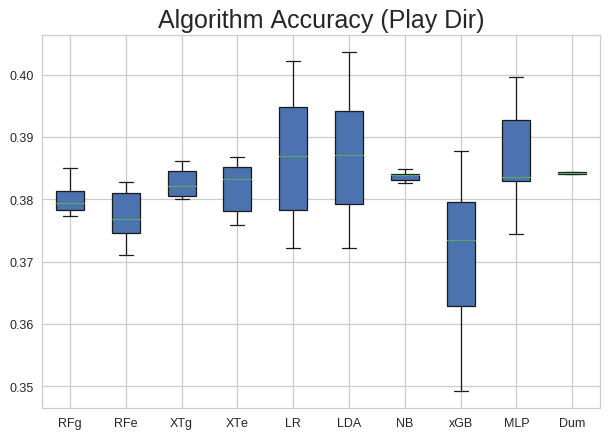

In [29]:
# Using only top 20 features
topf = features[idxDir[:20]]
print('All features:\n PLAY DIRECTION: left vs. middle vs. right\n')
# test algorithms for play direction
resDir, names = testAlgorithms(models, X, y2, (topf, featDir), cv_n, seed, scoring, suf='Dir')

All features:
 PLAY DIRECTION: left vs. middle vs. right

RFg: 0.37857661866 (0.0047203149098) acc (std)
RFe: 0.377852635476 (0.00545089475063) acc (std)
XTg: 0.376844474344 (0.00940814422488) acc (std)
XTe: 0.377159434899 (0.0086337761676) acc (std)
LR: 0.386854720745 (0.0101887702797) acc (std)


/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.387232703071 (0.0105592073939) acc (std)
NB: 0.383266845666 (0.00159886841762) acc (std)
xGB: 0.372501080581 (0.0120316108827) acc (std)
MLP: 0.373225707739 (0.00620719248349) acc (std)
Dum: 0.38421101392 (8.03974421019e-05) acc (std)


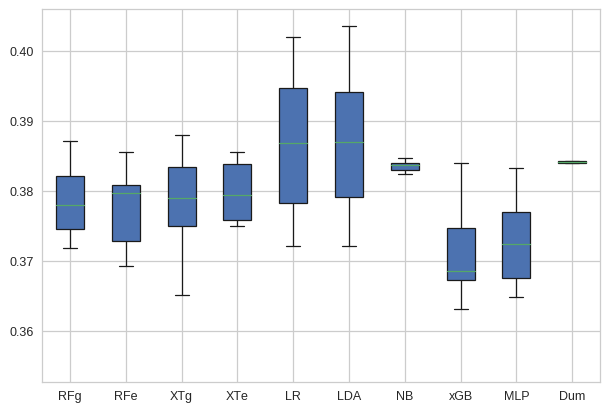

In [23]:
# Using ALL features
print('All features:\n PLAY DIRECTION: left vs. middle vs. right\n')
# test algorithms for play direction
resDir, names = testAlgorithms(models, X, y2, (features, featDir), cv_n, seed, scoring)

## No model predictions for play direction performs significantly above labeling each example with the most frequent class, so the remainder of analyses will focus on play type

In [30]:
# setup BINARY models
models = []
models.append(('RFg', RandomForestClassifier(criterion='gini', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('RFe', RandomForestClassifier(criterion='entropy', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('XTg', ExtraTreesClassifier(criterion='gini', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('XTe', ExtraTreesClassifier(criterion='entropy', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('LR', LogisticRegression(solver='lbfgs', class_weight='balanced'), False))#
models.append(('LDA', LinearDiscriminantAnalysis(), False))
models.append(('NB', GaussianNB(), False))
models.append(('xGB', XGBClassifier(n_estimators=500, nthread=-1), True))
models.append(('MLP', MLPClassifier(solver='lbfgs', hidden_layer_sizes=(500,), activation='tanh', alpha=1e-5, learning_rate_init=1e-3, learning_rate='constant', random_state=seed, momentum=0.7), True))
models.append(('Dum', DummyClassifier(strategy='most_frequent'), True))

In [26]:
features[idxTyp[:20]]

array([u'qtr_timef', u'yards_to_go', u'down', u'score_diff', u'yardfield',
       u'offense_yds_cum_gm', u'rushing_yds_cum_gm', u'passing_yds_cum_gm',
       u'passing_incmp_air_yds_cum_gm', u'receiving_yac_yds_cum_gm',
       u'offense_yds_sh1', u'week', u'type_rush_cum_gm',
       u'rushing_att_cum_gm', u'dir_right_cum_gm', u'type_pass_cum_gm',
       u'dir_left_cum_gm', u'passing_att_cum_gm', u'offense_yds_cum_dr',
       u'dir_middle_cum_gm'], 
      dtype='<U28')

Top 20 features only:
 PLAY TYPE: pass vs. rush

RFg: 0.693002663895 (0.010603963214) acc (std)
RFe: 0.694041696793 (0.0104681140918) acc (std)
XTg: 0.650949528683 (0.00463871160459) acc (std)
XTe: 0.651925301967 (0.0041039601035) acc (std)
LR: 0.656237388057 (0.00767725732648) acc (std)


/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.666184572621 (0.00719607588405) acc (std)
NB: 0.463439437124 (0.0562654849769) acc (std)
xGB: 0.664258874384 (0.0327139233626) acc (std)
MLP: 0.665932594162 (0.0135581942625) acc (std)
Dum: 0.606660589851 (7.93579701123e-05) acc (std)


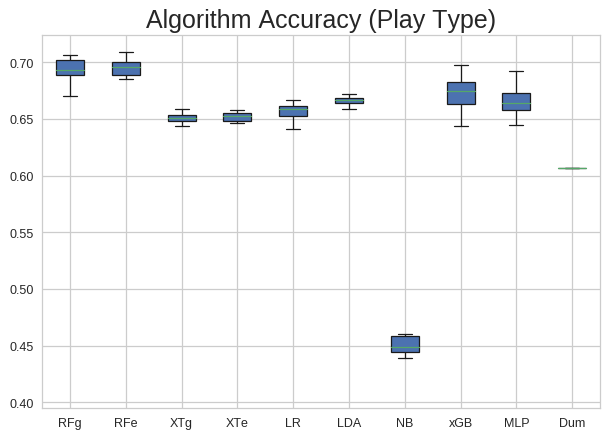

In [31]:
# Using only top 20 features
topf = features[idxTyp[:20]]
print('Top 20 features only:\n PLAY TYPE: pass vs. rush\n')
# test algorithms for play type
resTyp, names = testAlgorithms(models, X, y1, (topf, featTyp), cv_n, seed, scoring, suf='Type')

All features:
 PLAY TYPE: pass vs. rush

RFg: 0.680412218492 (0.00738916308604) acc (std)
RFe: 0.678617597348 (0.00731151687315) acc (std)
XTg: 0.638170037477 (0.00412359570385) acc (std)
XTe: 0.637414300646 (0.00381547898646) acc (std)
LR: 0.656237388057 (0.00767725732648) acc (std)


/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.666184572621 (0.00719607588405) acc (std)
NB: 0.463439437124 (0.0562654849769) acc (std)
xGB: 0.687366356478 (0.0126656197155) acc (std)
MLP: 0.661744501087 (0.0091887521235) acc (std)
Dum: 0.606660589851 (7.93579701123e-05) acc (std)


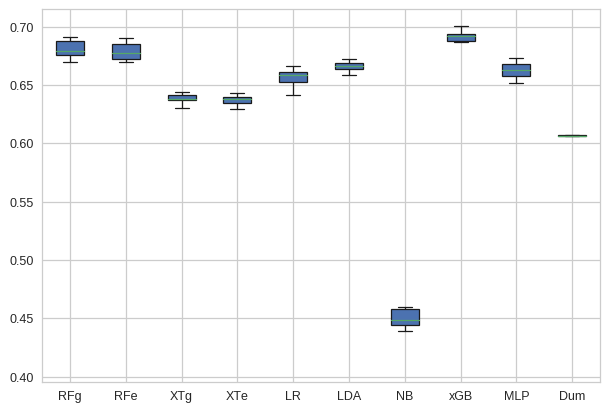

In [28]:
# Using ALL features
print('All features:\n PLAY TYPE: pass vs. rush\n')
# test algorithms for play type
resTyp, names = testAlgorithms(models, X, y1, (features, featTyp), cv_n, seed, scoring)

In [ ]:
features[idxTyp[:100]]
off_def = [feature for feature in features if feature.startswith('off_') or feature.startswith('def_')]

## Ensembling Algorithms w/ Majority Vote

In [29]:
def ensembleMajVote(pred, bestRep):
    pred = np.array(pred).transpose()
    # replicate best performing predictions
    rep = np.tile(pred[:, 2], (bestRep, 1)).T
    pred = np.concatenate([pred, rep], axis=1)
    m = st.mode(pred, axis=1)
    predictions = [c[0] for c in m[0]]
    counts = m[1]
    return predictions

In [30]:
# Using only top 20 features
topf = features[idxTyp[:20]]
print('Top 20 features only:\n PLAY TYPE: pass vs. rush\n')
# test algorithms for play type
predTyp, names = testAlgorithms(models[:-1], X, y1, (topf, featTyp), cv_n, seed, 'predict', plot=False)

Top 20 features only:
 PLAY TYPE: pass vs. rush



/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [31]:
# LR greedy features for LR, NB, and LDA
# top 20 RF features for rest
predT = ensembleMajVote(predTyp, bestRep=0)
acc = sum(predT == y1) / len(y1)
acc

0.68368535364663663

## Ensembling Algorithms w/ Blending Probabilities

In [11]:
def blend_proba(clfs, blender, X, y, X_bTest, featTup, n_folds, seed, shuffle=True, verbose=True):
    dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
    dataset_blend_test = np.zeros((X_bTest.shape[0], len(clfs)))
    
    skf = StratifiedKFold(n_folds, shuffle=shuffle, random_state=seed)
    j = 0
    ModNames = []
    for name, clf, colinear in clfs:
        ModNames.append(name)
        # select either (non)colinear features depending on model assumptions
        if colinear:
            x = X[featTup[0]]
            x_bTest = X_bTest[featTup[0]]
        else:
            x = X[featTup[1]]
            x_bTest = X_bTest[featTup[1]]
        dataset_blend_test_j = np.zeros((x_bTest.shape[0], n_folds))
        accuracies = np.array([])
        for i, (train, test) in enumerate(skf.split(x, y)):
            # print "Fold", i
            X_train = x.iloc[train]#.apply(featureNorm)
            y_train = y.iloc[train]
            X_test = x.iloc[test]
            y_test = y.iloc[test]
            clf.fit(X_train, y_train)
            probj = clf.predict_proba(X_test)[:, 1]
            dataset_blend_train[test, j] = probj
            accuracies = np.append(accuracies, accuracy_score(y_test, clf.predict(X_test)))
            dataset_blend_test_j[:, i] = clf.predict_proba(x_bTest)[:, 1]
        dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
        print("{0}: {1} ({2}) acc (std)".format(name, accuracies.mean(), accuracies.std()))
        j += 1
    
    clfnm, clf = blender[0], blender[1]
    print "Blending w/ {}...".format(clfnm)
    clf.fit(dataset_blend_train, y)
    yhat = clf.predict_proba(dataset_blend_test)[:, 1]
    
    # "Linear stretch of predictions to [0,1]"
    yhats = (yhat - yhat.min()) / (yhat.max() - yhat.min())
    ir = IsotonicRegression()
    try:
        yhat_ = ir.fit_transform(yhat, y)
    except Exception:
        yhat_ = []
        pass
    # feature importance, std, and max sorted index
    importance, std, idx = [], [], []
    if clfnm[:2] in ['RF', 'XT']:
        ModNames = np.asarray(ModNames)
        importance = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
        indices = np.argsort(importance)[::-1]
        # Plot the Forest's feature importances for each CV split
        fig, ax = plt.subplots()
        ax.set_title("Feature importances: Blender {}".format(clfnm))
        ax.bar(range(len(importance)), importance[indices],
               color="b", yerr=std[indices], align="center")
        ax.set_xticks(range(len(importance)))
        ax.set_xticklabels(ModNames[indices], rotation='vertical')
        # ax.set_xticklabels(map(str, indices), rotation='vertical')
        ax.set_xlim([-1, len(importance)])
        plt.title('Blending Model Importances', fontsize=20)
        fig = plt.gcf()
        fig.savefig('figs/blend_importances_playTyp.png', bbox_inches='tight', pad_inches=0)
        plt.show()
    
    return yhats, yhat_, dataset_blend_train, dataset_blend_test#, importance, std, indices

In [10]:
# setup BINARY models for Blending
models = []
models.append(('RFg', RandomForestClassifier(criterion='gini', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('RFg5', RandomForestClassifier(class_weight='balanced_subsample', criterion='gini', n_estimators=500, max_depth=5, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('RFe', RandomForestClassifier(criterion='entropy', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('XTg', ExtraTreesClassifier(criterion='gini', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('XTe', ExtraTreesClassifier(criterion='entropy', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('LR', LogisticRegression(solver='lbfgs', class_weight='balanced'), False))#
models.append(('LDA', LinearDiscriminantAnalysis(), False))
models.append(('xGB', XGBClassifier(n_estimators=500, max_depth=9, objective='binary:logistic', reg_lambda=1, reg_alpha=0), True))
models.append(('xGB3', XGBClassifier(n_estimators=500, max_depth=3, objective='binary:logistic', reg_lambda=4, reg_alpha=.05, learning_rate=0.1), True))
models.append(('xGB6', XGBClassifier(n_estimators=500, max_depth=6, objective='binary:logistic', reg_lambda=4, reg_alpha=.05, learning_rate=0.1, subsample=0.66, colsample_bytree=0.66), True))
models.append(('MLP', MLPClassifier(solver='lbfgs', hidden_layer_sizes=(500,), activation='tanh', alpha=1e-3, learning_rate_init=1e-2, learning_rate='constant', random_state=seed, momentum=0.7), True))
models.append(('SVM', SVC(kernel='linear', C=0.5, probability=True, class_weight='balanced'), True))
#models.append(('SVMrbf', SVC(gamma=2, C=3, probability=True, class_weight='balanced'), True))
models.append(('kNN', KNeighborsClassifier(5, n_jobs=-1), True))
models.append(('Dum', DummyClassifier(strategy='most_frequent'), True))

Algorithm Blending w/ RFe:
 Top 80 features:
 PLAY TYPE: pass vs. rush

RFg: 0.683791695482 (0.00809792402561) acc (std)
RFg5: 0.658994366015 (0.00490891035875) acc (std)
RFe: 0.681133251851 (0.0092511379573) acc (std)
XTg: 0.642871338006 (0.00740655889735) acc (std)
XTe: 0.642661241862 (0.00758188345932) acc (std)
LR: 0.655987299535 (0.00585312658888) acc (std)
LDA: 0.666198900262 (0.00869466151075) acc (std)
xGB: 0.69921610779 (0.00930755247589) acc (std)
xGB3: 0.708553913028 (0.00571267085604) acc (std)
xGB6: 0.699285817801 (0.00557828425164) acc (std)
MLP: 0.643047814616 (0.00858803841063) acc (std)
SVM: 0.64374601429 (0.00633534073955) acc (std)
kNN: 0.591389325809 (0.00602934459063) acc (std)
Blending w/ RFe...


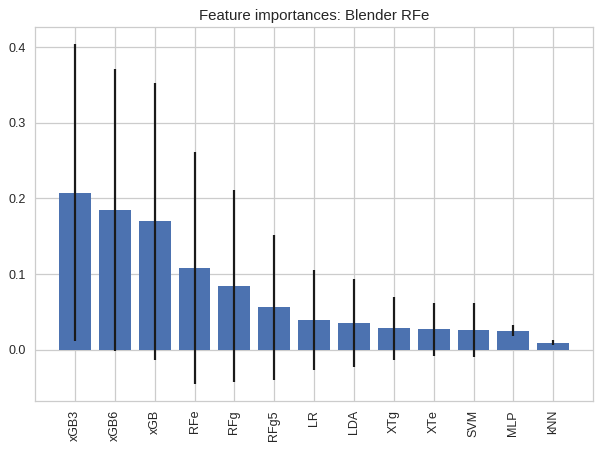

Blending Accuracy: 0.727101038716


In [45]:
# blender idx
bi = 2
# Using ALL features
topf = features[idxTyp[:80]]
topf = np.append(topf, off_def)
print('Algorithm Blending w/ {0}:\n Top 80 features:\n PLAY TYPE: pass vs. rush\n'.format(models[bi][0]))
# hold out 10% of samples for blending test
Xtr, X_bTest, ytr, y_bTest = train_test_split(X, y1, test_size=.10, random_state=seed)
# blend algorithms for play type
blender = models[bi]
pred_blend, pred_blend_, blend_train, blend_test = blend_proba(models[:-1], blender, Xtr, ytr, X_bTest, (topf, featTyp), cv_n, seed)
pred_blend[pred_blend>0.5] = 1
pred_blend[pred_blend<=0.5] = 0
print('Blending Accuracy: {0}'.format(accuracy_score(pred_blend, y_bTest)))

## Initial exploration of 6 class classification combining play type and direction
This performed poorly

PLAY 6 Class


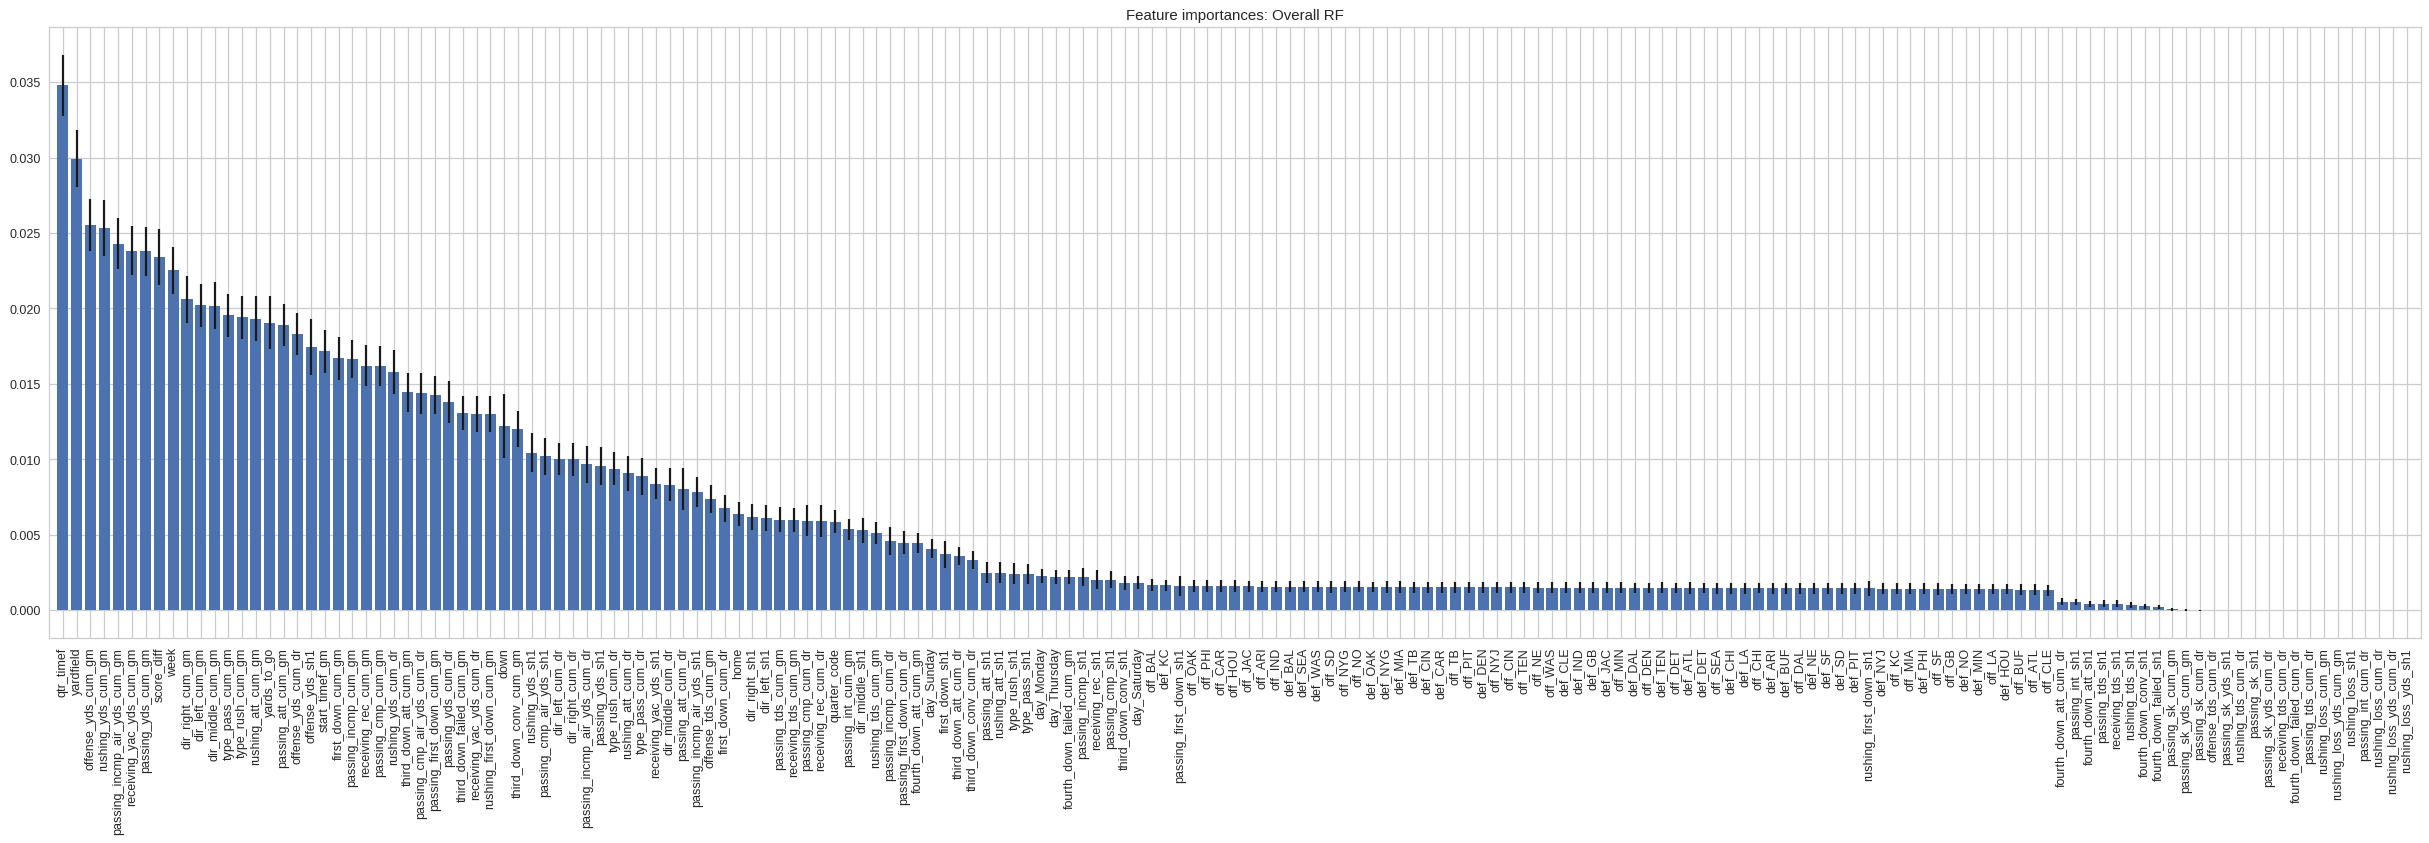

In [11]:
# get OVERALL feature importances for 6 class problem
print('PLAY 6 Class')
imp, std, idx = rfFeatureImp(X, play_code, seed, suf='6')

In [9]:
# setup MULTICLASS models
models = []
models.append(('RFg', RandomForestClassifier(criterion='gini', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('RFe', RandomForestClassifier(criterion='entropy', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('XTg', ExtraTreesClassifier(criterion='gini', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('XTe', ExtraTreesClassifier(criterion='entropy', n_estimators=500, max_depth=9, min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('LR', LogisticRegression(solver='lbfgs', class_weight='multinomial'), False))#
models.append(('LDA', LinearDiscriminantAnalysis(), False))
models.append(('NB', MultinomialNB(), False))
models.append(('xGB', XGBClassifier(n_estimators=500, objective='multi:softmax', nthread=-1), True))
models.append(('MLP', MLPClassifier(solver='lbfgs', hidden_layer_sizes=(500,), activation='tanh', alpha=1e-5, learning_rate_init=1e-3, learning_rate='constant', random_state=seed, momentum=0.7), True))
models.append(('Dum', DummyClassifier(strategy='most_frequent'), False))

Top 20 features only:
 PLAY (6 class)

RFg: 0.259025755386 (0.00369570448197) acc (std)
RFe: 0.25861804972 (0.00500875360885) acc (std)
XTg: 0.245081112228 (0.00352088436682) acc (std)
XTe: 0.24612035393 (0.00368476281816) acc (std)
LR: 0.255723097251 (0.0083036122186) acc (std)


/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.255406858159 (0.00600074738896) acc (std)
NB: 0.243916441901 (0.00559403473171) acc (std)
xGB: 0.231793903594 (0.0173240315121) acc (std)
MLP: 0.250589952108 (0.00623430205621) acc (std)
Dum: 0.244609612827 (0.00015126609684) acc (std)


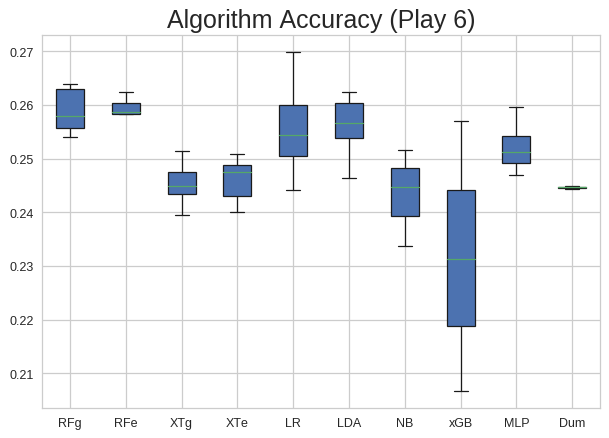

In [13]:
# Using only top 20 features
topf = features[idx[:20]]
print('Top 20 features only:\n PLAY (6 class)\n')
# test algorithms for play type
resTyp, names = testAlgorithms(models, X, play_code, (topf, featTyp), cv_n, seed, scoring, suf='6')